In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook



In [2]:
size = 100
# noise_std = 5e-2
# alpha = .2
# lr = 1e-2

noise_std = 1e-2
alpha = .1
lr = 1e-3


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)
net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True)


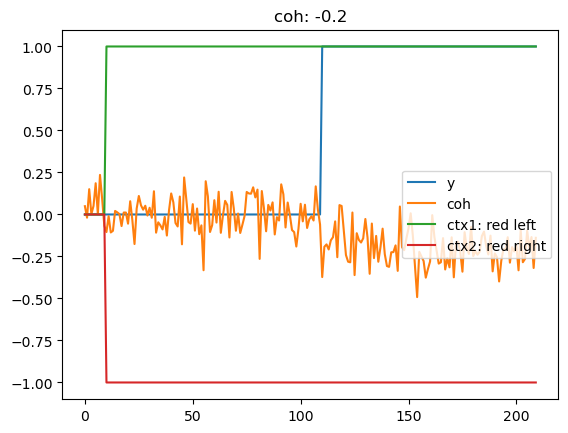

In [4]:
n = 4

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], label = 'ctx1: red left')
plt.plot(x_val[n,:,2], label = 'ctx2: red right')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




# train a full-rank RNN

In [5]:


net.non_linearity = torch.relu
net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr / sqrt(size), batch_size=50, keep_best=True, cuda=True, early_stop=0.2)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)

# will only choose 1 of the 2  
# out = net.forward(x_val)
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the model
# torch.save(net.state_dict(), f'../models/TF{size}.pt')

Training...
initial loss: 1.001
epoch 0:  loss=0.980  (took 9.83 s) *
epoch 1:  loss=0.862  (took 9.56 s) *
epoch 2:  loss=0.626  (took 9.26 s) *
epoch 3:  loss=0.415  (took 9.35 s) *
epoch 4:  loss=0.346  (took 9.23 s) *
epoch 5:  loss=0.312  (took 9.34 s) *
epoch 6:  loss=0.282  (took 9.26 s) *
epoch 7:  loss=0.255  (took 9.21 s) *
epoch 8:  loss=0.239  (took 9.22 s) *
epoch 9:  loss=0.221  (took 9.24 s) *
epoch 10:  loss=0.210  (took 9.39 s) *
epoch 11:  loss=0.197  (took 9.36 s) *
loss=0.195, acc=1.000


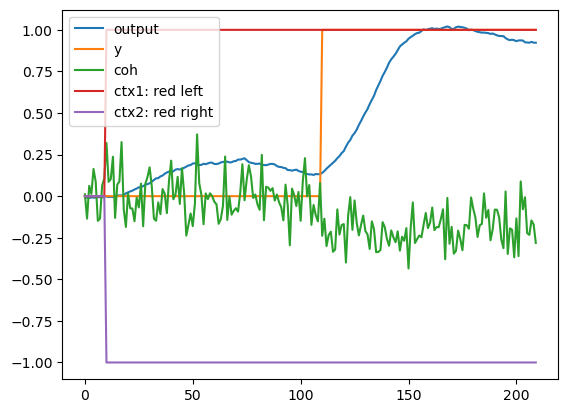

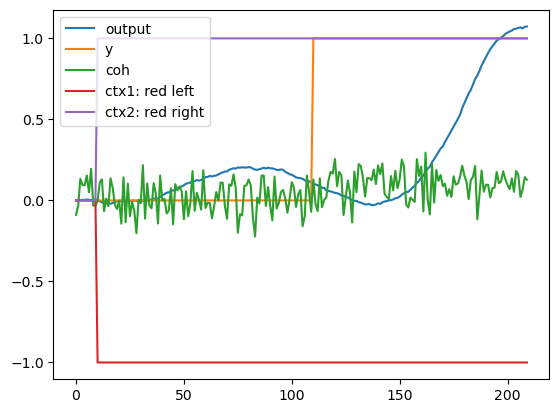

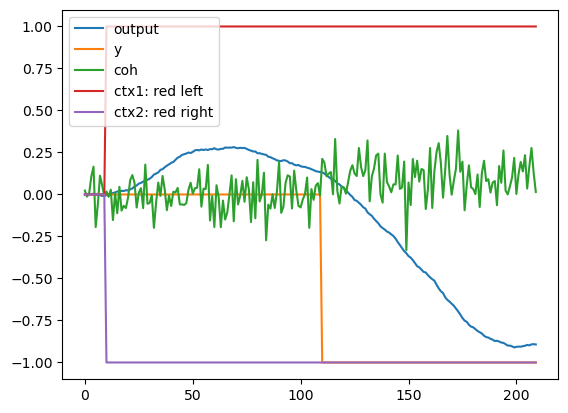

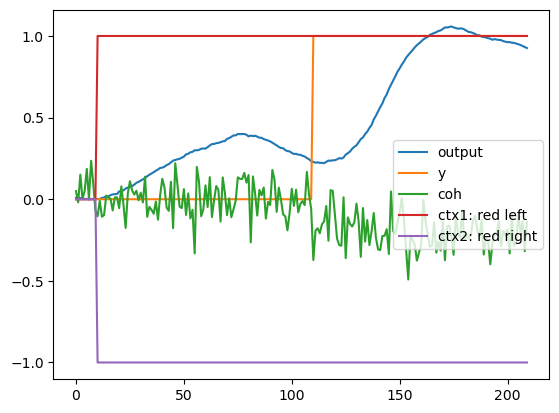

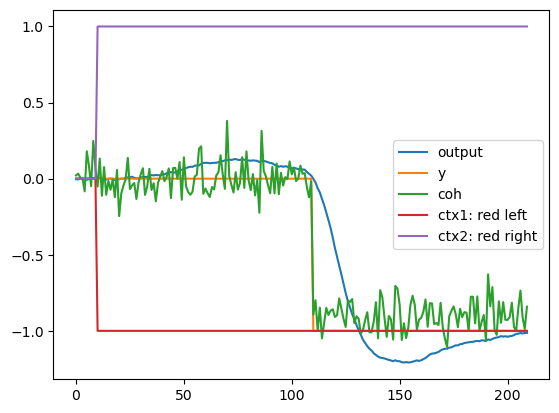

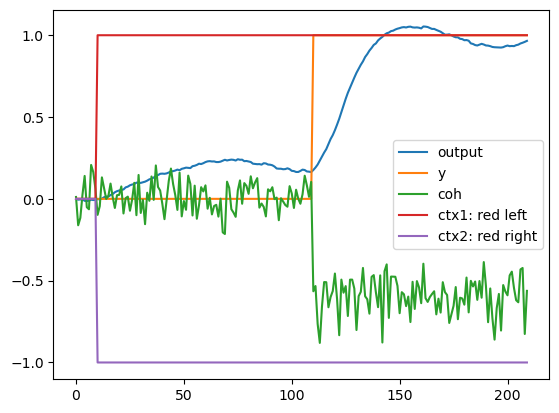

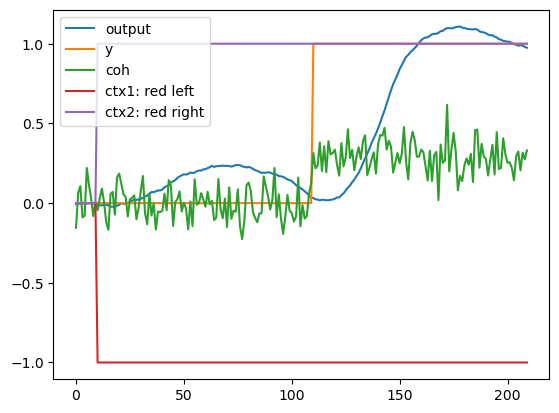

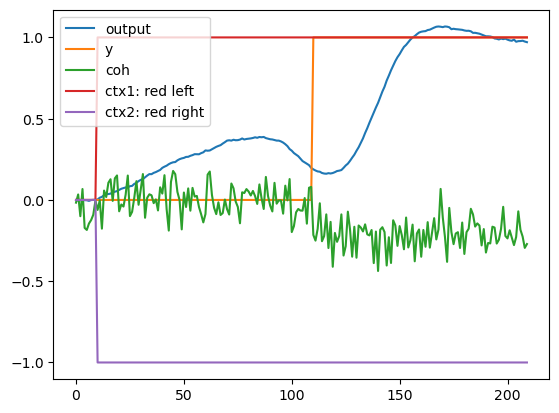

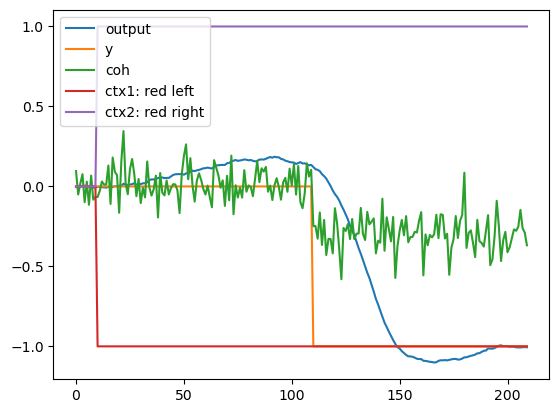

In [6]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [7]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

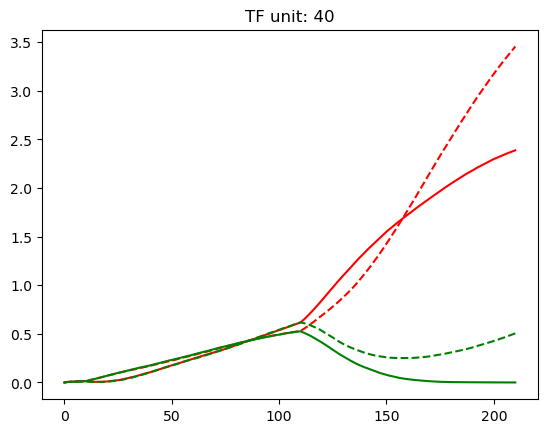

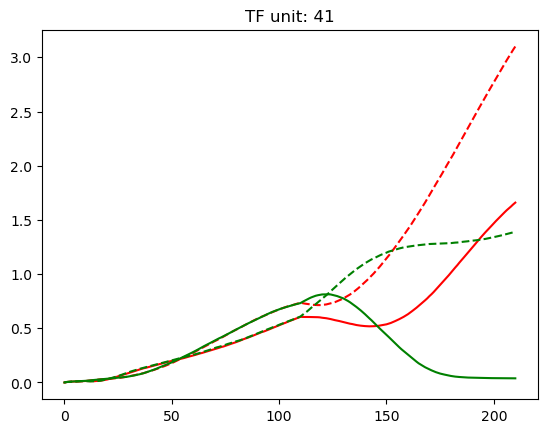

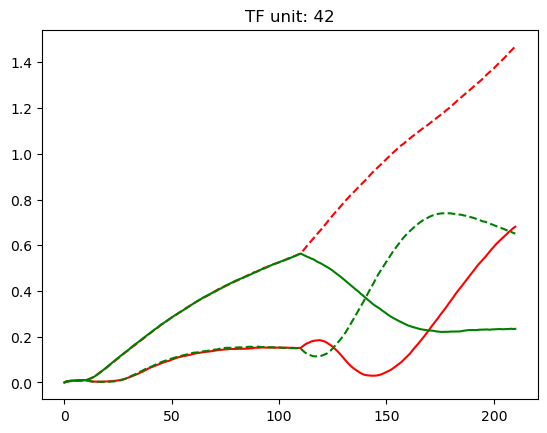

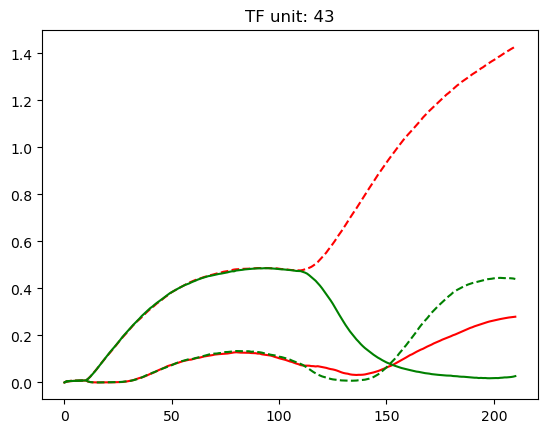

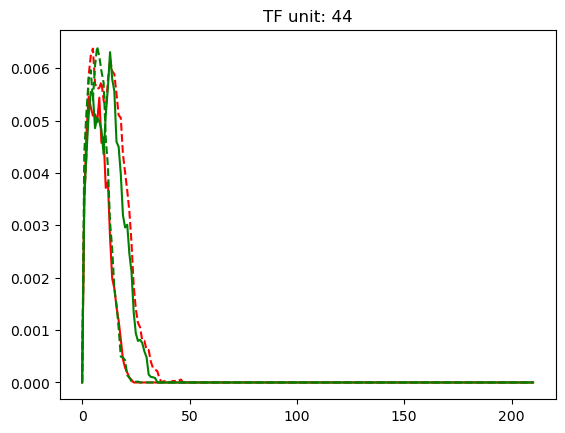

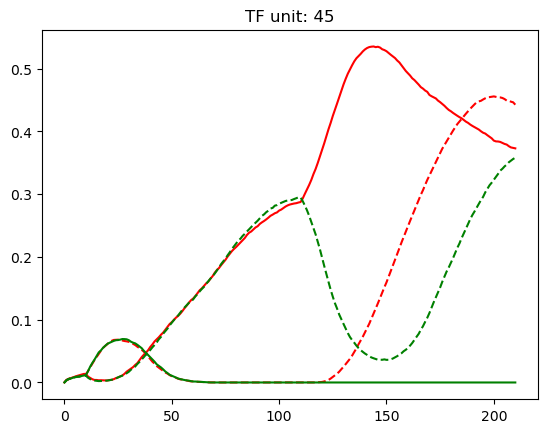

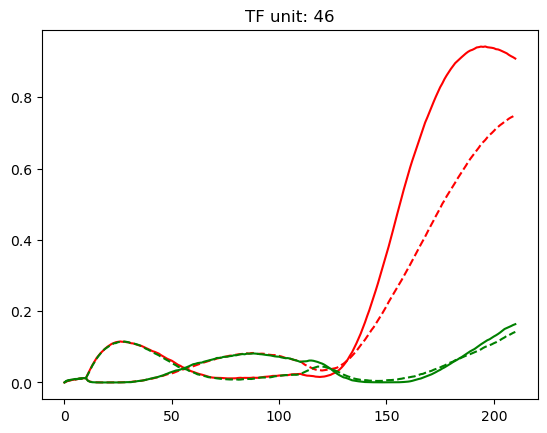

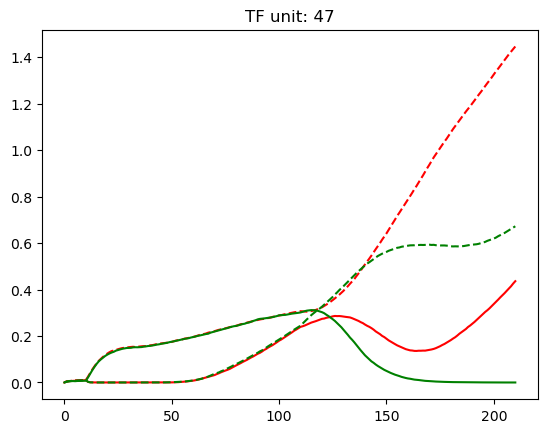

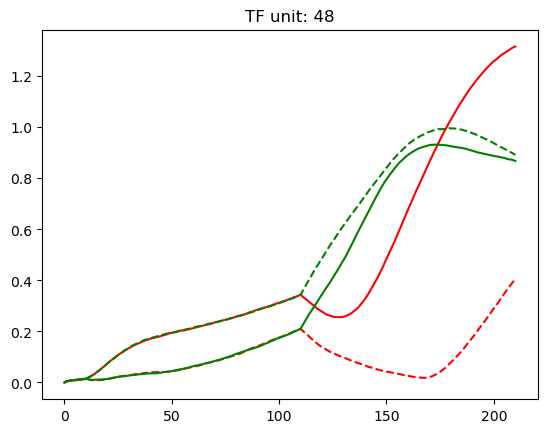

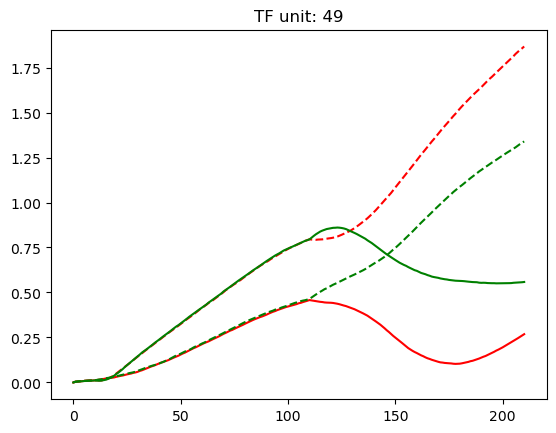

In [11]:
for n in range(40,50):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# train low-rank RNN

In [4]:
# load a full-rank RNN

net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/TF{size}.pt', map_location='cpu'))

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.037, acc=1.000


In [3]:
# define some parameters
# hidden_size: # units in low-rank RNN (should match that in full-rank RNN)
hidden_size = 100
rank = 4

In [6]:
# you have to save model for full-rank RNN, then use that to train low-rank RNN 



# reduce the rank of connectivity matrix 
wi_init = net.wi_full.detach()
wo_init = net.wo_full.detach() * hidden_size
print(wo_init.std())
wrec = net.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(7.2830)
tensor(2.6485)
tensor(1.0005)
torch.Size([100, 4])
torch.Size([100, 4])


In [11]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(1000)


In [7]:


# We see that the rank-1 network 
net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)

train(net_lo, x_train, y_train, mask_train, n_epochs=10, lr=lr, batch_size=50, keep_best=True, cuda=True, clip_gradient=1, early_stop=0.05)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)
# out = net_lo.forward(x_val)
# print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')



Training...
initial loss: 0.472
epoch 0:  loss=0.131  (took 9.89 s) *
epoch 1:  loss=0.050  (took 10.00 s) *
loss=0.044, acc=1.000


In [25]:
# save the low-rank model
# torch.save(net_lo.state_dict(), "../models/TF_rank4_1_{}.pt".format(hidden_size))


In [4]:
# load a low-rank RNN

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=4)
net_lo.load_state_dict(torch.load(f'../models/TF_rank4_{size}.pt', map_location='cpu'))

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')


loss=67.531, acc=0.527


# Plot psth

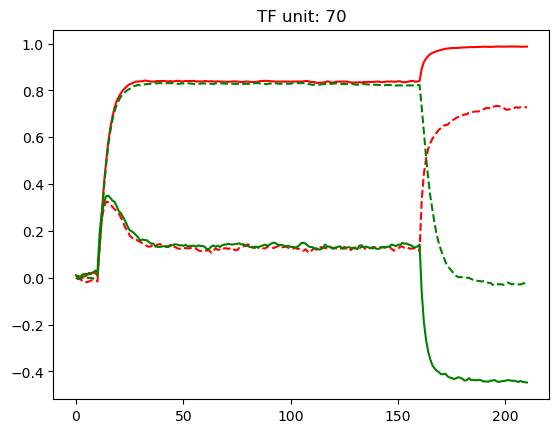

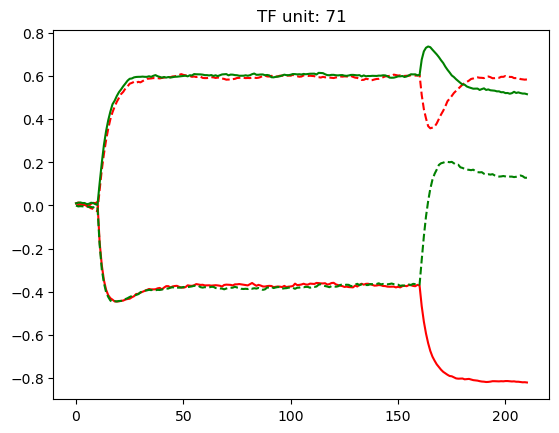

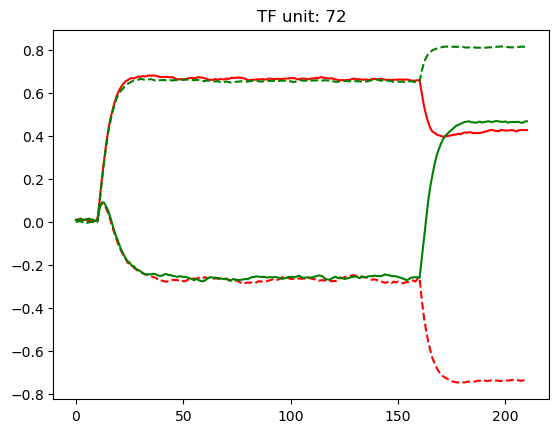

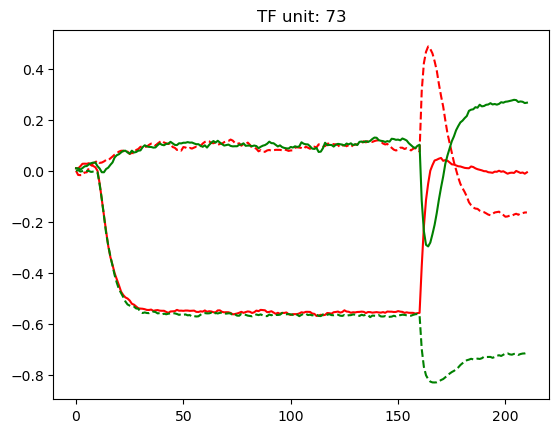

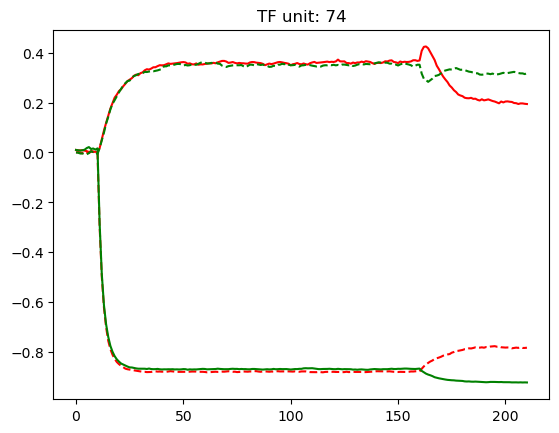

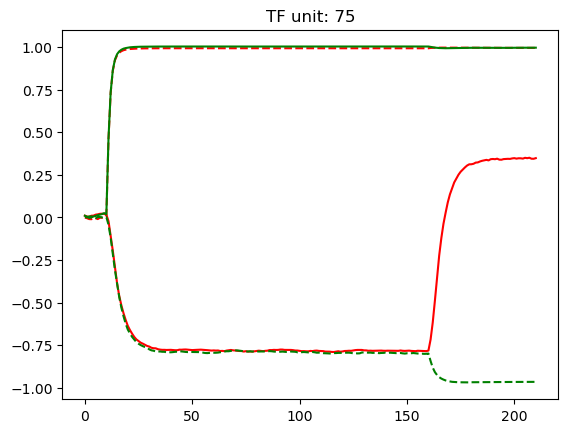

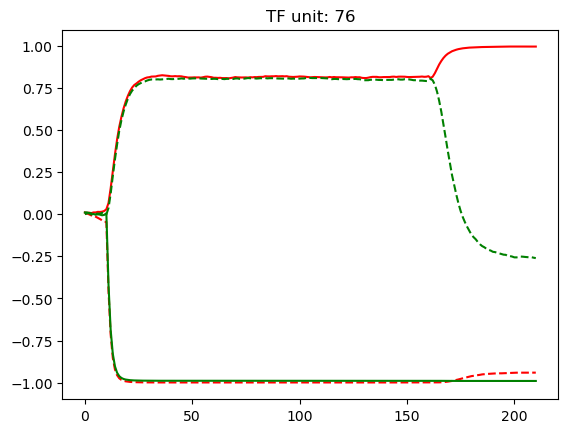

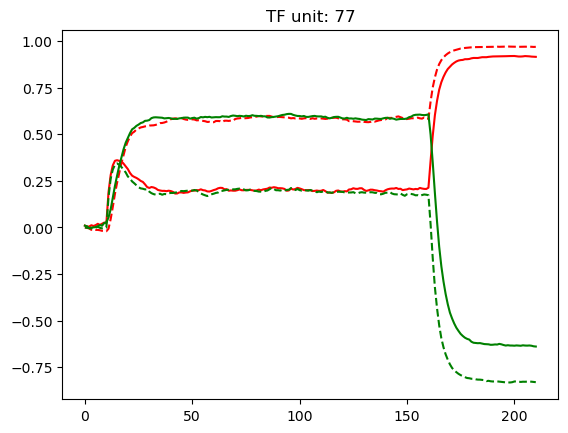

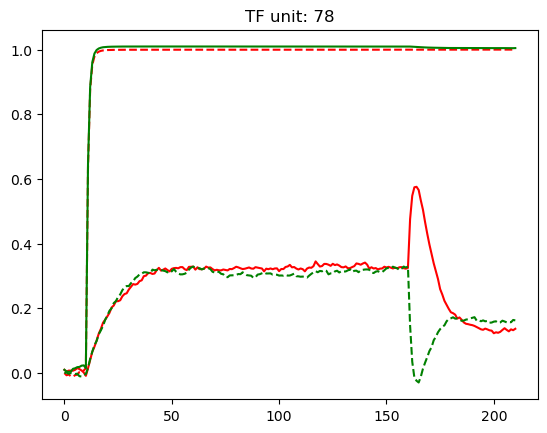

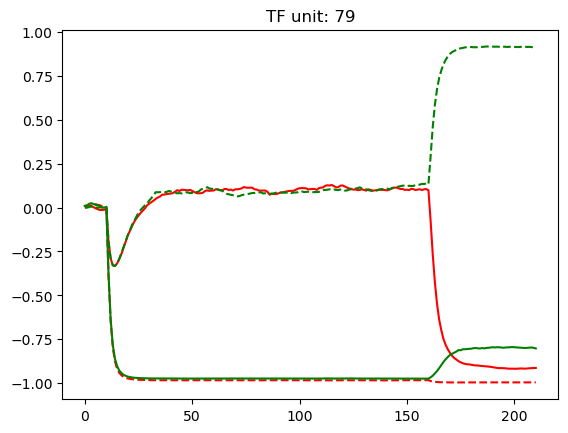

In [4]:
traj1 = traj.detach().numpy()

traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(70,80):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

# full-tank vs low-rank

In [5]:
# # load model
# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# net = FullRankRNN(3, size, 1, noise_std, alpha)
# net.load_state_dict(torch.load(f'../models/TF{size}.pt', map_location='cpu'))

# net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank)
# net_lo.load_state_dict(torch.load(f'../models/TF_rank3_{size}.pt', map_location='cpu'))
# # net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=net_tmp.wi_full, m_init=net_tmp.m, n_init=net_tmp.n, 
# #                   wo_init=net.wo_full * size)
# loss, acc, _, _, _, _ = TF.test_checker(net, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')

# loss, acc, _, _, _, _ = TF.test_checker(net_lo, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')


In [6]:
# # ## remember to change the net.nonlinearity

# fig, ax = plt.subplots(figsize=(5, 2))
# outp, traj = net.forward(x_val, return_dynamics=True)
# outp2, traj2 = net_lo.forward(x_val, return_dynamics=True)

# traj = traj.detach().numpy()
# traj2 = traj2.detach().numpy()
# r2_global = stats.r2_score(np.tanh(traj).ravel(), np.tanh(traj2).ravel())

# print(r2_global)
# r2s = stats.r2_idneurons(traj, traj2, return_all=True)
# print(np.median(r2s))
# sns.boxplot(r2s, orient='horizontal', color='silver', ax=ax)
# plt.xlim(-1, 1)

In [4]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()
n4 = net_lo.n[:, 3].detach().numpy()


# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()
m4 = net_lo.m[:, 3].detach().numpy()


wo = net_lo.wo.detach().squeeze().numpy()

In [5]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.038, acc=1.000


In [7]:
# generate 4 trials, each represent a condition
# x = TF.generate_ordered_inputs()

# _, trajFull = net.forward(x, return_dynamics=True)
# _, trajLow = net_lo.forward(x, return_dynamics=True)

# trajFull = trajFull.detach().numpy()
# trajLow = trajLow.detach().numpy()

In [8]:
# for ii in range(10,20):
#     plt.figure()
#     plt.plot(trajLow[0,:,ii], 'r-')
#     plt.plot(trajLow[1,:,ii], 'r--')
#     plt.plot(trajLow[2,:,ii], 'g-')
#     plt.plot(trajLow[3,:,ii], 'g--')
#     plt.show()

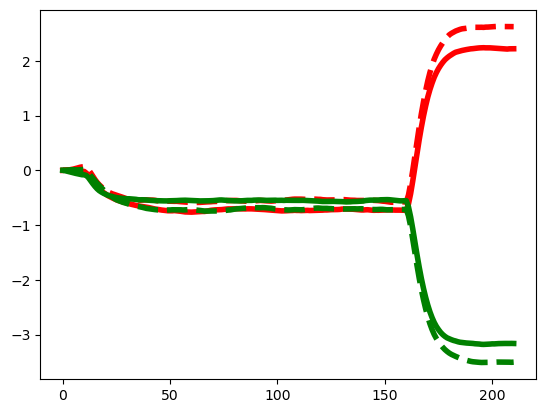

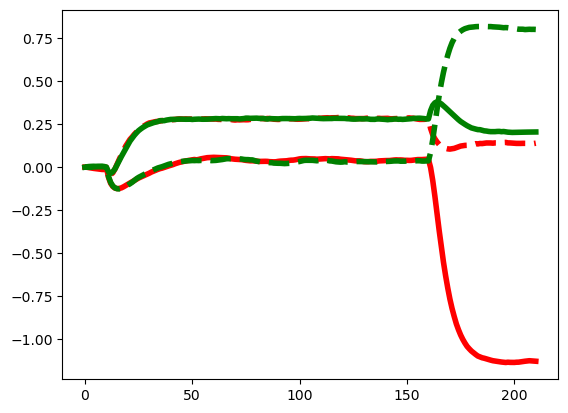

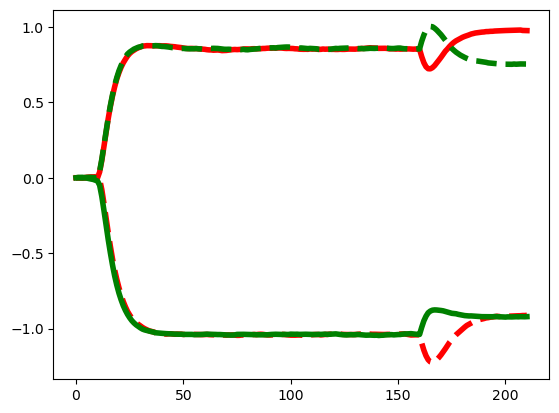

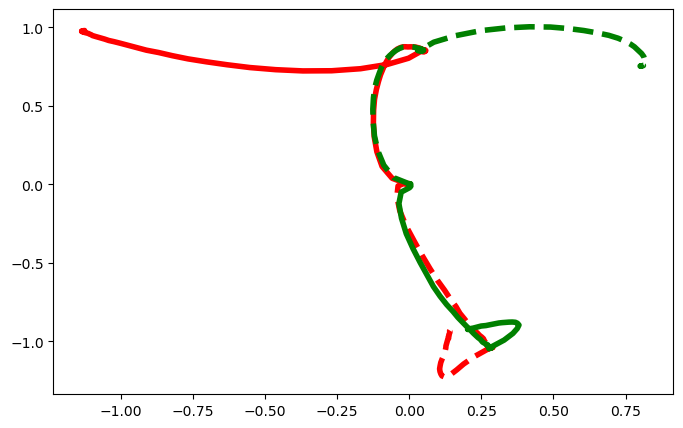

In [6]:
# project full rank rnn traj on m1 vector
# kap1 = trajFull @ m1 / size
# kap2 = trajFull @ m2 / size

# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
kap4 = trajLow @ m4 / size


colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
plt.figure()
for i in range(4):
    plt.plot(kap1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap3[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

# plt.figure()
# for i in range(4):
#     plt.plot(kap4[i], c=colors[i], lw=4, ls=lineStyle[i])
# plt.show()

plt.subplots(figsize=(8,5))
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
     plt.plot(kap2[i], kap3[i], c=colors[i], lw=4, ls=lineStyle[i])


In [9]:
# # full rank RNN pca
# colors = ['red', 'red', 'green', 'green']
# lineStyle = ['-', '--', '-', '--']
# TOn = 10
# COn = 80

# pca = plot.pca_cumvar(trajFull, n_components=10)
# plt.ylim(0, 1.02)
# plt.axhline(1, ls='--', c='gray')
# plt.show()



# ax1 = pca.components_[0]
# ax2 = pca.components_[1]
# ax3 = pca.components_[2]
# ax4 = pca.components_[3]

# k1 = trajFull @ ax1
# k2 = trajFull @ ax2
# k3 = trajFull @ ax3
# k4 = trajFull @ ax4

# plt.figure()
# for i in range(4):
#     plt.plot(k2[i], k1[i], c=colors[i], lw=4, ls = lineStyle[i])
# plt.show()
    
# # 3D pca plot
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for i in range(4):
#     plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
#     ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
#             marker='.', s=400)
#     ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
#             marker='.', s=400)

# # ax.view_init(elev=38, azim=90)
# plt.show()

(844, 100)


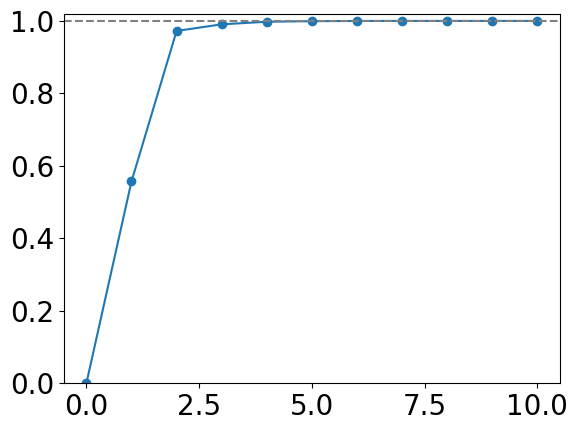

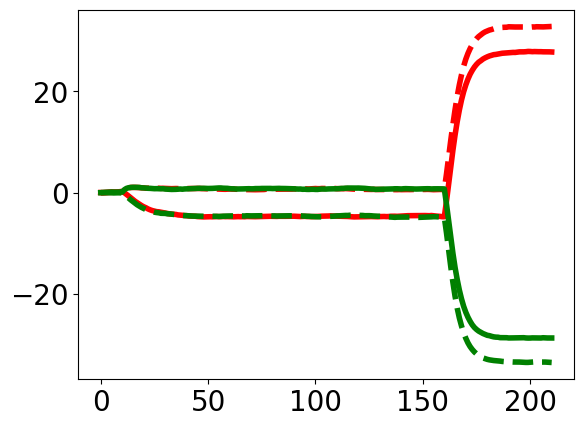

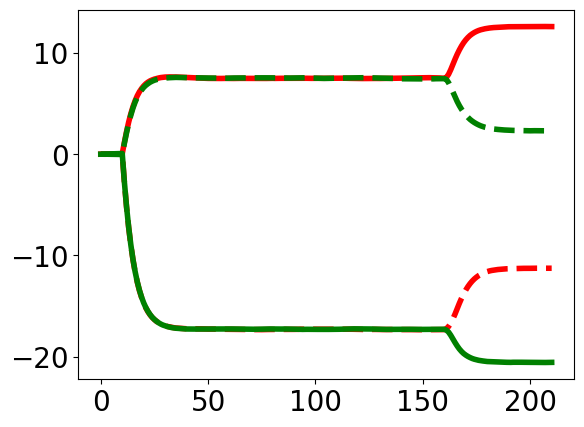

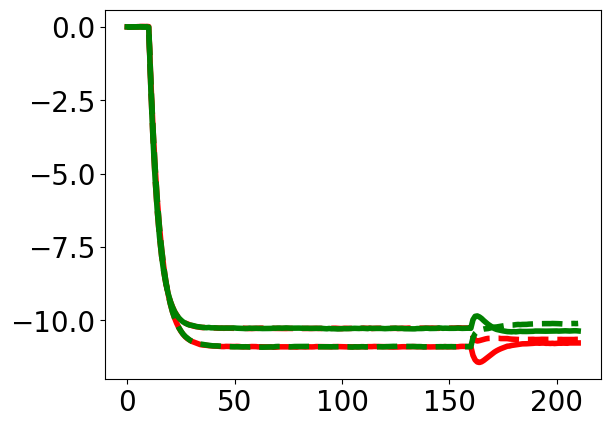

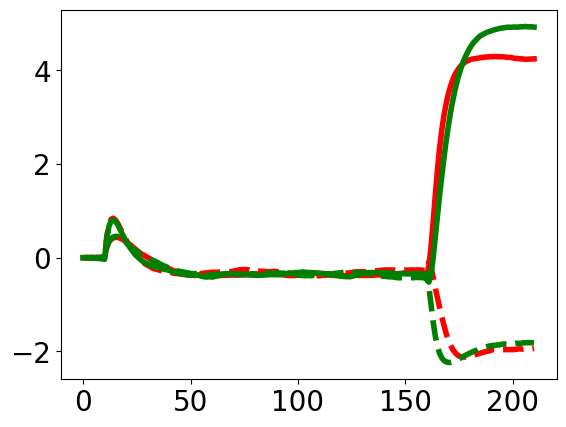

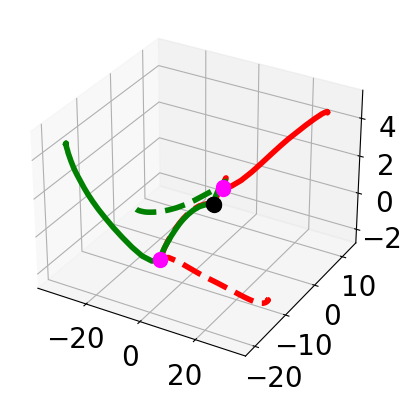

In [44]:
# low rank RNN pca
TOn = 10
COn = 160

pca = plot.pca_cumvar(trajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajLow @ ax1
k2 = trajLow @ ax2
k3 = trajLow @ ax3
k4 = trajLow @ ax4

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k4[i, COn], c= 'magenta',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

In [51]:
PCtraj = np.zeros([3, k1.shape[0], k1.shape[1]])

PCtraj[0,:,:] = k1
PCtraj[1,:,:] = k2
PCtraj[2,:,:] = k4

# save dataframe as mat file 
import scipy.io
mdic = {'PCtraj': PCtraj}
scipy.io.savemat('../PCtraj.mat', mdic)

<IPython.core.display.Javascript object>


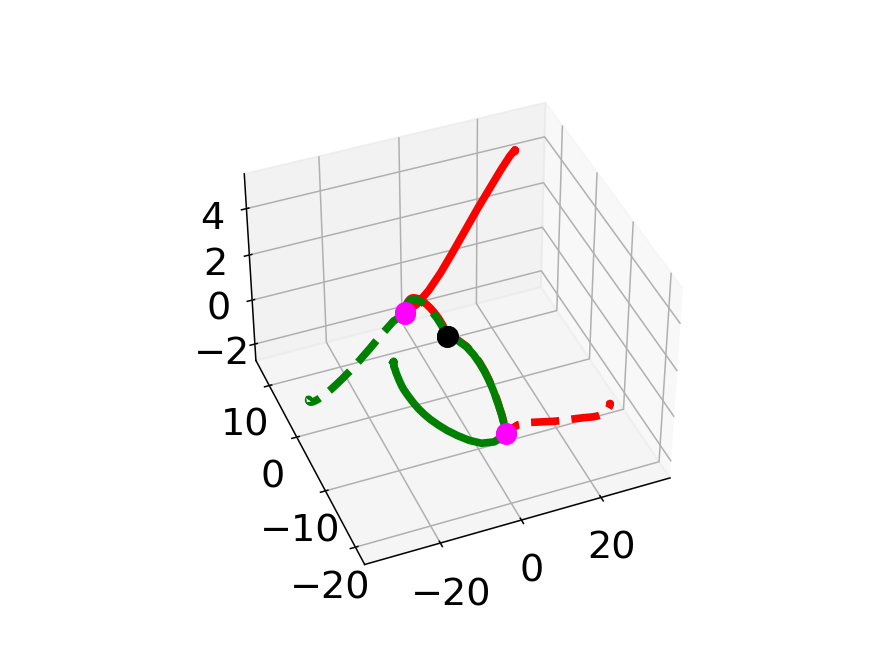

In [48]:
%matplotlib notebook

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k4[i, COn], c= 'magenta',
            marker='.', s=400)

ax.view_init(elev=40, azim=-112)
plt.show()

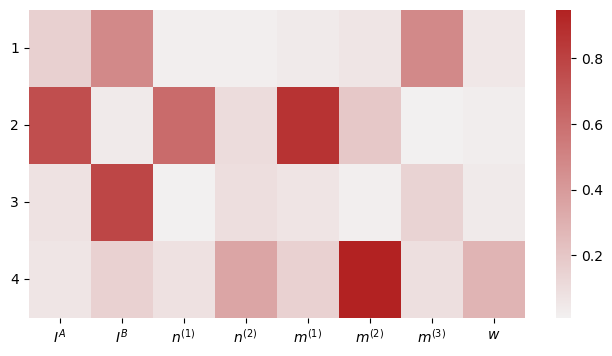

In [11]:
vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, m3, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 8, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$m^{(3)}$','$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

# fields

In [52]:
# 1st way to generate low-traj
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000, coherences = [-0.9,0.9])

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)


kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
kap4 = trajLow @ m4 / size

loss=0.013, acc=1.000


In [18]:
# # generate 4 trials, each represent a condition
# x = TF.generate_ordered_inputs()
# _, trajLow = net_lo.forward(x, return_dynamics=True)
# trajLow = trajLow.detach().numpy()

# kap1 = trajLow @ m1 / size
# kap2 = trajLow @ m2 / size
# kap3 = trajLow @ m3 / size
# kap4 = trajLow @ m4 / size

<IPython.core.display.Javascript object>


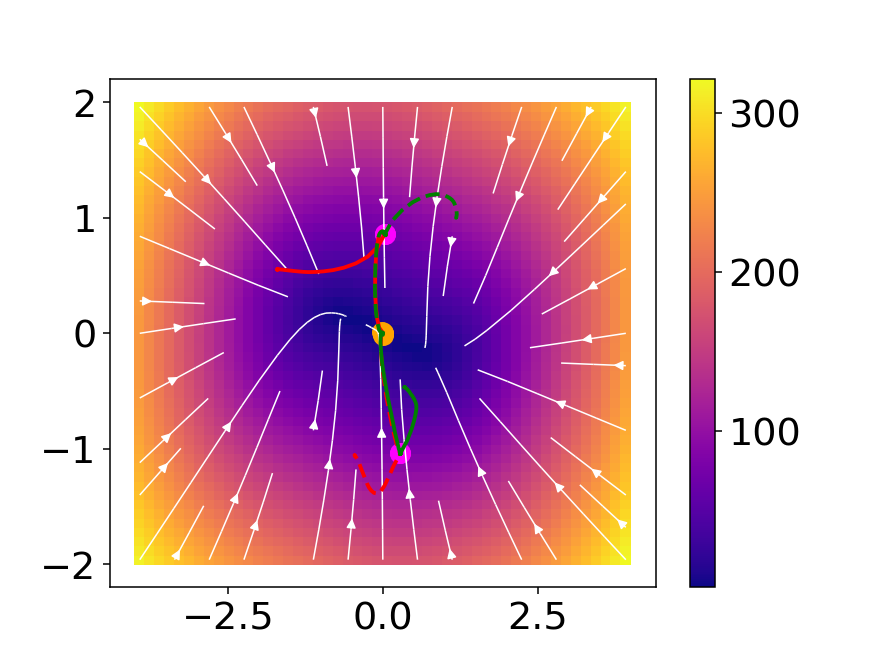

In [53]:
# whole epoch
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m2, m3, -4, 4, -2, 2)
mappable.set_cmap('plasma')
plt.colorbar(mappable)

for i in range(4):
     plt.plot(kap2[i], kap3[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap2[i, TOn], kap3[i, TOn], c= 'orange',
            marker='.', s=400)  
     plt.scatter(kap2[i, COn], kap3[i, COn], c= 'magenta',
            marker='.', s=400)  
        
# # plt.savefig('TFtraj4_1.pdf', bbox_inches='tight')
        
plt.show()

<AxesSubplot:>

In [20]:
mappable

<IPython.core.display.Javascript object>


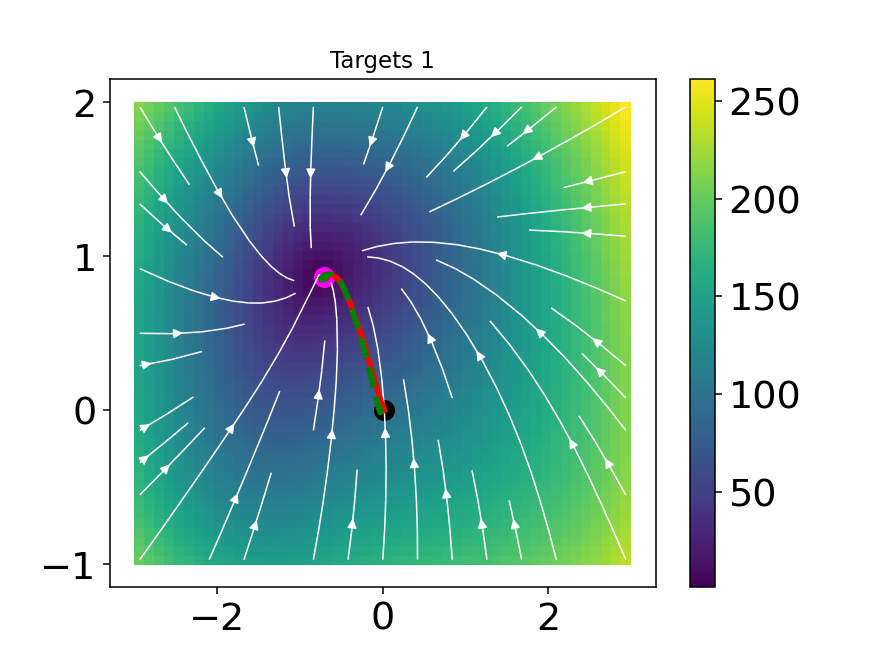

<IPython.core.display.Javascript object>


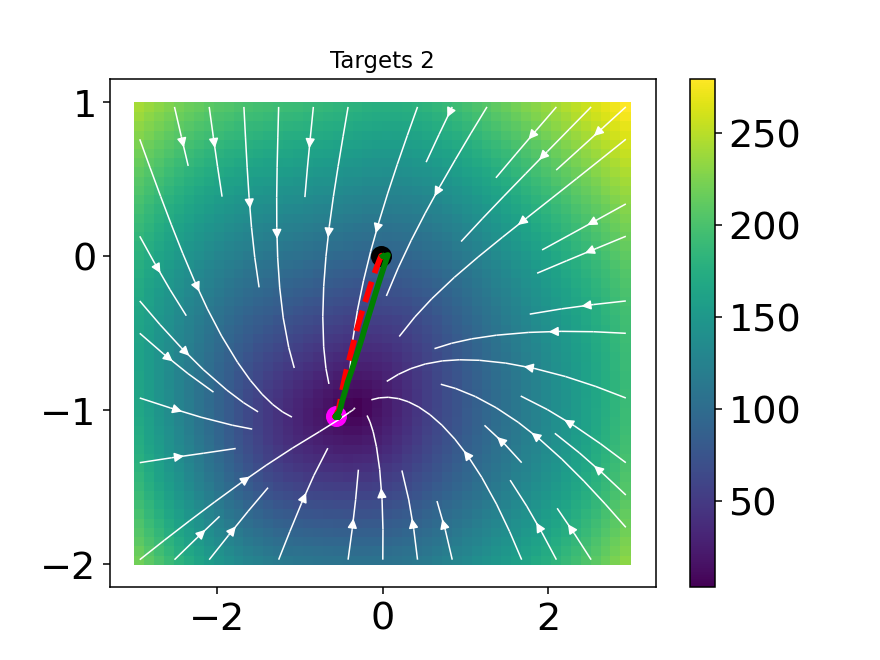

In [58]:
# only target epoch
kap1T = kap1[:,:160]
kap3T = kap3[:,:160]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m3, -3, 3, -1, 2, input=torch.tensor([0.,1, 0]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1T[0], kap3T[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.plot(kap1T[3], kap3T[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap1[0, TOn], kap3[0, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[0, COn], kap3[0, COn], c= 'magenta',
    marker='.', s=400) 
        
plt.title('Targets 1')        
# plt.savefig('TFT1.pdf', bbox_inches='tight')
        
plt.show()

# target 1 epoch 
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m3, -3, 3, -2, 1, input=torch.tensor([0.,0, 1]))
mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1T[1], kap3T[1], c=colors[0], lw=3, ls=lineStyle[1])
plt.plot(kap1T[2], kap3T[2], c=colors[3], lw=3, ls=lineStyle[2])
plt.scatter(kap1[1, TOn], kap3[1, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[1, COn], kap3[1, COn], c= 'magenta',
    marker='.', s=400) 
        
plt.title('Targets 2')        
# plt.savefig('TFT2.pdf', bbox_inches='tight')
        
plt.show()




<IPython.core.display.Javascript object>


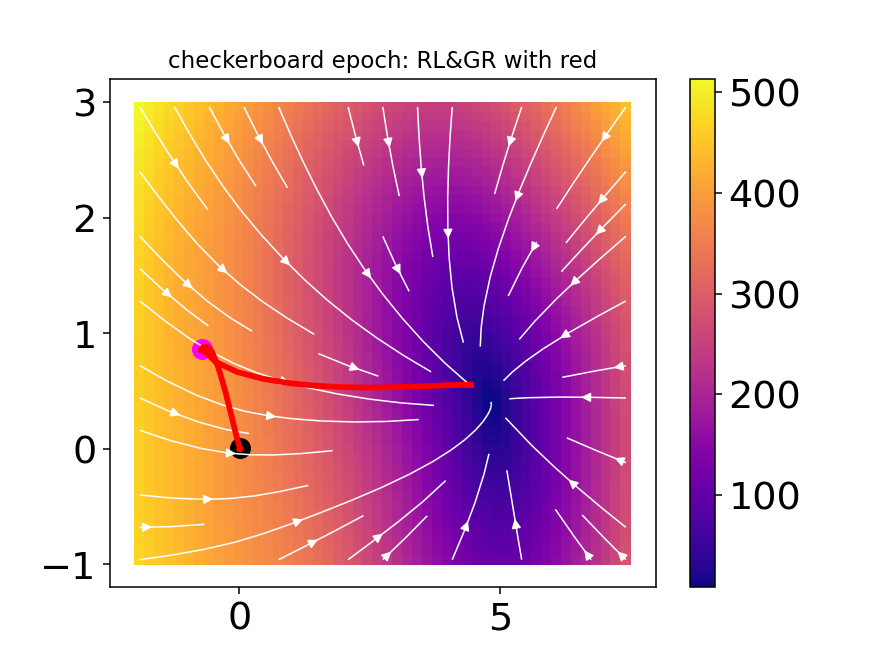

<IPython.core.display.Javascript object>


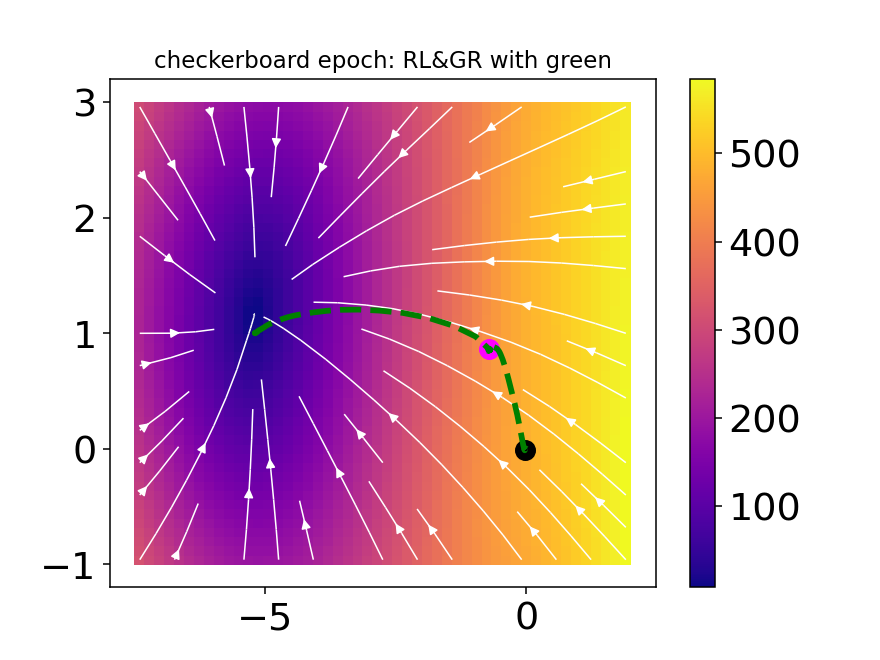

In [55]:

# checkerboard epoch
kap1C = kap1[:,160:]
kap3C = kap3[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m3, -2, 7.5, -1, 3, input=torch.tensor([0.9,1, 0]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1[0], kap3[0], c=colors[0], lw=3, ls=lineStyle[0])
plt.scatter(kap1[0, TOn], kap3[0, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[0, COn], kap3[0, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RL&GR with red')        
plt.savefig('TFT1R.pdf', bbox_inches='tight')
        
plt.show()






# checkerboard epoch
kap1C = kap1[:,160:]
kap3C = kap3[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m3, -7.5, 2, -1, 3, input=torch.tensor([-0.9,1, 0]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1[3], kap3[3], c=colors[3], lw=3, ls=lineStyle[3])
plt.scatter(kap1[3, TOn], kap3[3, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[3, COn], kap3[3, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RL&GR with green')        
plt.savefig('TFT1G.pdf', bbox_inches='tight')
        
plt.show()







<IPython.core.display.Javascript object>


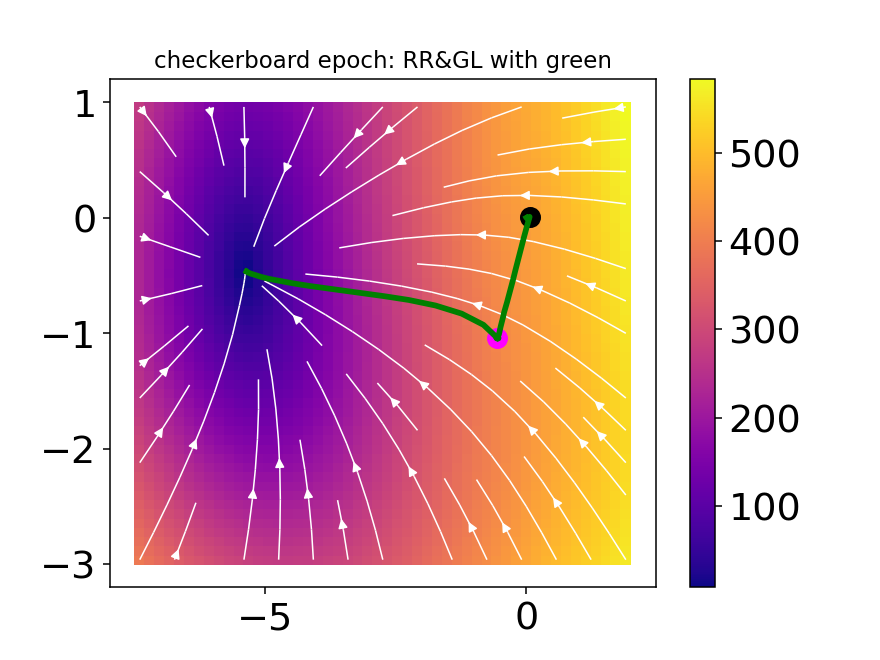

<IPython.core.display.Javascript object>


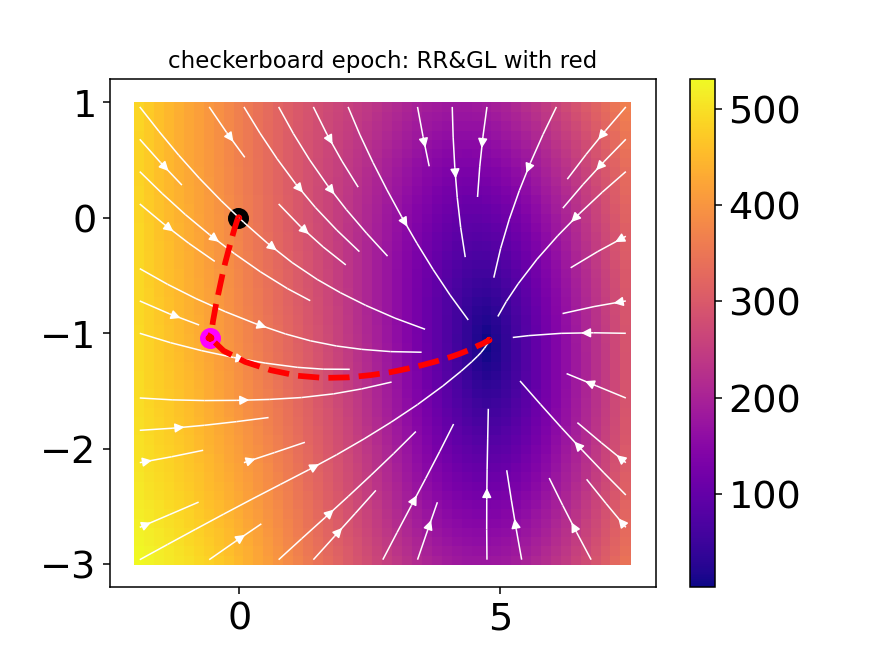

In [56]:

# checkerboard epoch
kap1C = kap1[:,160:]
kap3C = kap3[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

[ax, mappable] = ranktwo.plot_field(net_lo, m1, m3, -7.5, 2, -3, 1, input=torch.tensor([-0.9,0, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)


plt.plot(kap1[2], kap3[2], c=colors[2], lw=3, ls=lineStyle[2])
plt.scatter(kap1[2, TOn], kap3[2, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[2, COn], kap3[2, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RR&GL with green')        
plt.savefig('TFT2R.pdf', bbox_inches='tight')
        
plt.show()







# checkerboard epoch
kap1C = kap1[:,160:]
kap3C = kap3[:,160:]
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m1, m3, -2, 7.5, -3, 1, input=torch.tensor([0.9,0, 1]))

mappable.set_cmap('viridis')
plt.colorbar(mappable)

plt.plot(kap1[1], kap3[1], c=colors[1], lw=3, ls=lineStyle[1])
plt.scatter(kap1[1, TOn], kap3[1, TOn], c= 'k',
    marker='.', s=400)  
plt.scatter(kap1[1, COn], kap3[1, COn], c= 'magenta',
    marker='.', s=400) 

plt.title('checkerboard epoch: RR&GL with red')        
plt.savefig('TFT2G.pdf', bbox_inches='tight')
        
plt.show()

In [11]:
a = =torch.tensor([1.,0])
a.shape

SyntaxError: invalid syntax (1837042359.py, line 1)

In [19]:
x = TF.generate_ordered_inputs()
x.shape

torch.Size([4, 210, 3])

In [20]:
b = x[1].reshape((1, -1, 3))

In [21]:
b.shape

torch.Size([1, 210, 3])

In [24]:
bb = torch.tensor([0.,1])
bb.shape

torch.Size([2])

In [58]:
kap1.shape

(4, 211)

# interrupt analysis

In [112]:
def generateinterrput(num_trials, interrupt_type): 
    # generate interrupt targets configuration inputs
    inputs, off_time, _, allContext = TF.generate_interrupt_inputs(num_trials, interrupt_type = 'targets')

    y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
    traj_inter1 = traj_inter.detach().numpy()
    off_time1 = off_time.detach().numpy()



    # project low rank rnn traj on m1 vector
    kap1 = traj_inter1 @ m1 / size
    kap2 = traj_inter1 @ m2 / size
    kap3 = traj_inter1 @ m3 / size
    
    return kap1, kap2, kap3

In [113]:
# generate target and color interrupt trials
[kap1, kap2, kap3] = generateinterrput(3, 'targets')
[kapC1, kapC2, kapC3] = generateinterrput(3, 'color')

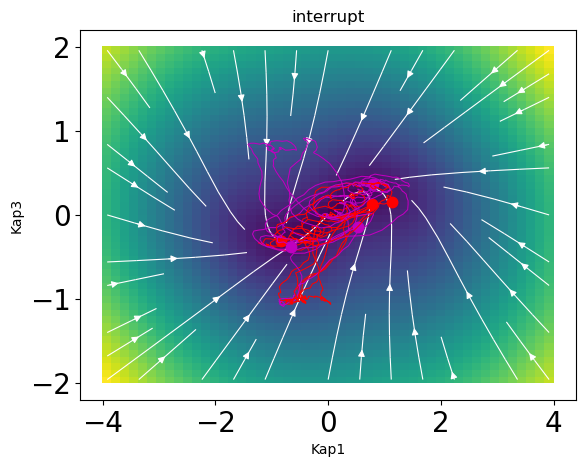

In [114]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -4, 4, -2, 2)
for i in range(kap1.shape[0]):
     plt.plot(kap1[i,:], kap3[i,:], color = 'red',linewidth=0.75)
     plt.plot(kapC1[i,:], kapC3[i,:], color = 'm',linewidth=0.75)
     plt.plot(kapC1[i,-1], kapC3[i,-1], '.', markersize = 15, color = 'm')
     plt.plot(kap1[i,-1], kap3[i,-1], '.', markersize = 15, color = 'red')

plt.xlabel('Kap1')
plt.ylabel('Kap3')

plt.title('interrupt')
# plt.savefig('TFinter4_1.pdf', bbox_inches='tight')

plt.show()